In [1]:
import pandas as pd
invite = pd.read_csv('data/invited_info_train.txt', sep='\t', header=None)
question = pd.read_csv('data/question_info.txt', sep='\t', header=None)
user = pd.read_csv('data/user_info.txt', sep='\t', header=None)
validate = pd.read_csv('data/validate_nolabel.txt', sep=',')

In [2]:
# deal with text with word2vec
import numpy as np
import gensim
def transform(series, dimension=100):
    row = series.index
    sentenses = series.str.split('/').dropna()
    model = gensim.models.Word2Vec(sentenses, workers=4, min_count=1, size=dimension)
    out = []
    for sentence in sentenses:
        result = np.zeros(dimension)
        count = 0
        for word in sentence:
            result += model[word]
            count +=1
        result = result / float(count)
        out.append(result)
    df = pd.DataFrame(out , index=sentenses.index).reindex(row).fillna(0)
    return df

In [3]:
# formulate the feature
question_new = pd.concat([question.drop([2,3], axis=1), transform(question[2]), transform(question[3])], axis=1)
user_new = pd.concat([user.drop([1,2,3], axis=1), transform(user[1], 50),
                          transform(user[2]), transform(user[3])], axis=1)

In [4]:
# conbine three files
left = invite
right1 = user_new
right2 = question_new
left.columns = validate.columns
right1_columns = [left.columns[1]]
right1_columns.extend(list(range(right1.columns.size-1)))
right1.columns = right1_columns
right2_columns = [left.columns[0]]
right2_columns.extend(list(range(right2.columns.size-1)))
right2.columns = right2_columns
left = pd.merge(left, right1, how='left', on=[invite.columns[1]])
left = pd.merge(left, right2, how='left', on=[invite.columns[0]])

In [5]:
# get data and label
data = left.drop(invite.columns, axis=1)
label = left[invite.columns[2]]

In [6]:
# deal with missing data and normalization
from sklearn.preprocessing import StandardScaler, Imputer
impute = Imputer()
data = pd.DataFrame(impute.fit_transform(data), index=data.index)
std = StandardScaler()
data = pd.DataFrame(std.fit_transform(data), index=data.index)

In [7]:
# train test split
from sklearn.cross_validation import train_test_split
train_data, test_data, train_label, test_label = train_test_split(data, label, random_state=456, 
                                                                  test_size=0.2, stratify=label)

In [8]:
# load model xgboost
from xgboost import XGBClassifier
gbm = XGBClassifier()

In [9]:
# test the model
gbm.set_params(**{'n_estimators':400, 'learning_rate':0.9})
gbm.fit(train_data, train_label, 
        eval_set = [(train_data, train_label), (test_data, test_label)],
        eval_metric = 'auc', verbose=True)

[0]	validation_0-auc:0.639905	validation_1-auc:0.637793
[1]	validation_0-auc:0.663669	validation_1-auc:0.66012
[2]	validation_0-auc:0.677421	validation_1-auc:0.67132
[3]	validation_0-auc:0.683496	validation_1-auc:0.676607
[4]	validation_0-auc:0.689872	validation_1-auc:0.683204
[5]	validation_0-auc:0.693818	validation_1-auc:0.687193
[6]	validation_0-auc:0.700872	validation_1-auc:0.692968
[7]	validation_0-auc:0.706448	validation_1-auc:0.699084
[8]	validation_0-auc:0.710676	validation_1-auc:0.702944
[9]	validation_0-auc:0.716017	validation_1-auc:0.707814
[10]	validation_0-auc:0.72099	validation_1-auc:0.712236
[11]	validation_0-auc:0.725222	validation_1-auc:0.715071
[12]	validation_0-auc:0.728501	validation_1-auc:0.71898
[13]	validation_0-auc:0.732307	validation_1-auc:0.722083
[14]	validation_0-auc:0.737013	validation_1-auc:0.728258
[15]	validation_0-auc:0.740421	validation_1-auc:0.730561
[16]	validation_0-auc:0.74436	validation_1-auc:0.732999
[17]	validation_0-auc:0.747713	validation_1-au

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.9, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=400, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

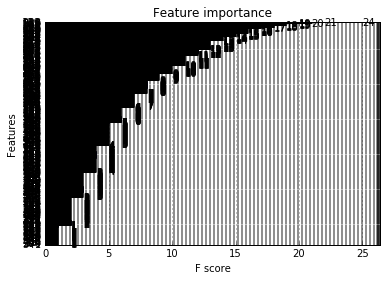

In [10]:
# plot the important feature
import xgboost
%matplotlib inline
xgboost.plot_importance(gbm.booster())

In [11]:
# reformulate feature
result = gbm.booster().get_fscore()
se = pd.Series(result)
important_feature = pd.to_numeric(se[lambda x: x>10].index)
data_important = data[important_feature]

In [12]:
# train and test split
from sklearn.cross_validation import train_test_split
train_data, test_data, train_label, test_label = train_test_split(data_important, label, random_state=456, 
                                                                  test_size=0.2, stratify=label)

In [34]:
# test
gbm.set_params(**{'n_estimators':600, 'learning_rate':0.9})
gbm.fit(train_data, train_label, 
        eval_set = [(train_data, train_label), (test_data, test_label)],
        eval_metric = 'auc', verbose=True)

[0]	validation_0-auc:0.611167	validation_1-auc:0.603303
[1]	validation_0-auc:0.627729	validation_1-auc:0.622694
[2]	validation_0-auc:0.642584	validation_1-auc:0.637834
[3]	validation_0-auc:0.674485	validation_1-auc:0.667526
[4]	validation_0-auc:0.679574	validation_1-auc:0.671694
[5]	validation_0-auc:0.684055	validation_1-auc:0.676221
[6]	validation_0-auc:0.691887	validation_1-auc:0.681951
[7]	validation_0-auc:0.69787	validation_1-auc:0.686599
[8]	validation_0-auc:0.702119	validation_1-auc:0.688734
[9]	validation_0-auc:0.706839	validation_1-auc:0.693315
[10]	validation_0-auc:0.709635	validation_1-auc:0.696154
[11]	validation_0-auc:0.711659	validation_1-auc:0.698682
[12]	validation_0-auc:0.715062	validation_1-auc:0.701199
[13]	validation_0-auc:0.718696	validation_1-auc:0.704695
[14]	validation_0-auc:0.722485	validation_1-auc:0.706796
[15]	validation_0-auc:0.725211	validation_1-auc:0.708911
[16]	validation_0-auc:0.727062	validation_1-auc:0.709912
[17]	validation_0-auc:0.73008	validation_1

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.9, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=600, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [41]:
# get the predicted label
pred_label = pd.Series(gbm.predict_proba(test_data)[:,1], index=test_data.index)

In [42]:
# formulate the df_true and df_pred
df_true = pd.concat([invite[['qid','uid']].ix[test_label.index,:], 
                     pd.DataFrame(test_label, columns=['label'])], axis=1)
df_pred = pd.concat([invite[['qid','uid']].ix[test_label.index,:], 
                     pd.DataFrame(pred_label, columns=['label'])], axis=1)

In [45]:
# calculate the evaluation result
from ndcg import ndcg_at_k
def evaluate(df_true, df_pred, column_name='qid', label_name='label', method=0):
    keys = df_true.groupby(column_name).groups
    score = 0.0
    count = 0
    
    for key in keys:
        true = df_true[df_true[column_name]==key][label_name]
        pred = df_pred[df_pred[column_name]==key][label_name]
        index = pred.sort_values(ascending=False).index
        r = true.reindex(index).tolist()
        ndcg5 = ndcg_at_k(r, 5, method)
        ndcg10 = ndcg_at_k(r, 10, method)
        result = (ndcg5+ndcg10)/2.0
        score += result
        count += 1
        print result
    return score/float(count)
        

In [46]:
# test result
r = evaluate(df_true, df_pred, method=1)

0.0
0.0
0.0
0.919720789148
0.0
1.0
1.0
1.0
1.0
0.0
0.0
0.833186623705
0.0
0.0
1.0
1.0
0.630929753571
0.5
0.0
0.0
0.0706334864299
0.0
0.0
0.0
0.0
1.0
0.5
0.0
0.386852807235
0.496056525644
0.0
0.0
1.0
0.0
0.0
0.0
0.71533839156
0.0
0.705435041155
0.0
1.0
1.0
0.893448060914
0.0
0.0
1.0
1.0
0.0
1.0
0.0
1.0
1.0
0.0
1.0
0.0
0.919720789148
0.0
1.0
1.0
0.0
0.202107346501
0.0
0.0
0.5
0.0
0.0
1.0
0.877215315338
1.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
0.630929753571
0.0
0.0
0.0
1.0
0.0
0.0
1.0
0.630929753571
0.0
1.0
0.306573596383
0.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
1.0
0.946902429526
1.0
0.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
0.877215315338
0.0
0.850344905535
0.0
0.0
0.0
0.0
0.0
1.0
0.0
1.0
0.630929753571
1.0
0.0
0.679731050004
0.0
1.0
0.0
0.0
1.0
0.0
0.0
1.0
0.0
1.0
0.0
0.0
0.0
0.0
0.0
1.0
0.630929753571
0.0
0.630929753571
0.609619950008
0.0
0.0
0.0
1.0
0.630929753571
0.967467983489
0.630929753571
0.0
0.0
0.693426403617
0.630929753571
0.0
0.630929753571
1.0
0.0
0.0
1.0
1.0
0.63092975357

In [47]:
r

0.38289588629749716

In [48]:
# get the predicted result of validation_nolabel
left = validate
right1 = user_new
right2 = question_new
#left.columns = validate.columns
right1_columns = [left.columns[1]]
right1_columns.extend(list(range(right1.columns.size-1)))
right1.columns = right1_columns
right2_columns = [left.columns[0]]
right2_columns.extend(list(range(right2.columns.size-1)))
right2.columns = right2_columns
left = pd.merge(left, right1, how='left', on=[validate.columns[1]])
left = pd.merge(left, right2, how='left', on=[validate.columns[0]])
data = left.drop(validate.columns, axis=1)
label = left['label']
from sklearn.preprocessing import StandardScaler, Imputer
impute = Imputer()
data = pd.DataFrame(impute.fit_transform(data), index=data.index)
std = StandardScaler()
data = pd.DataFrame(std.fit_transform(data), index=data.index)
data_important = data[important_feature]
pred_label = pd.Series(gbm.predict_proba(data_important)[:,1], index=data_important.index)
df_pred = pd.concat([validate[['qid','uid']].ix[label.index,:], 
                     pd.DataFrame(pred_label, columns=['label'])], axis=1)

In [54]:
# write the file
df_pred.to_csv('result/submit.csv', index=None, encoding='utf-8')